In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [4]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_summer, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net_summer, centers_summer, labels_summer = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net_summer.compute_populations()
coords = net_summer.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_summer = labels_to_centers(labels_summer, ds)
    ds_center_summer.to_netcdf(ds_center_path)
else:
    ds_center_summer = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels_summer)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net_summer.n_nodes)})

all_jets_center_summer = find_all_jets(xarray_to_polars(ds_center_summer), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_summer = is_polar_gmix(all_jets_center_summer, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

time


100%|██████████| 16/16 [00:00<00:00, 270.65it/s]


In [18]:
da_spring = dh.da.sel(time=spring.to_numpy())
dh_spring = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_spring, save_da=True)
exp_spring = Experiment(dh_spring)
nx, ny, n_pca = 2, 3, 200
net_spring, centers_spring, labels_spring = exp_spring.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net_spring.compute_populations()
coords = net_spring.neighborhoods.coordinates

ds_center_path = exp_spring.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_spring = labels_to_centers(labels_spring, ds)
    ds_center_spring.to_netcdf(ds_center_path)
else:
    ds_center_spring = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels_spring)
mask_da = xr.DataArray(mask, coords={"time": exp_spring.da.time, "cluster": np.arange(net_spring.n_nodes)})

all_jets_center_spring = find_all_jets(xarray_to_polars(ds_center_spring), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_spring = is_polar_gmix(all_jets_center_spring, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

100%|██████████| 6/6 [00:00<00:00, 530.09it/s]


(<Figure size 500x400 with 2 Axes>, <Axes: >)

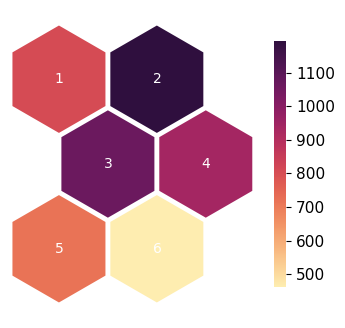

In [21]:
net_spring.plot_on_map(populations, numbering=True)

In [12]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels_spring.groupby(labels_spring.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 4 != 3:
        continue
    group = np.concatenate(group)
    coords = net_spring.neighborhoods.coordinates[labels_spring[group]]
    unique, count = np.unique(labels_spring[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net_spring.x
    maxdy = net_spring.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

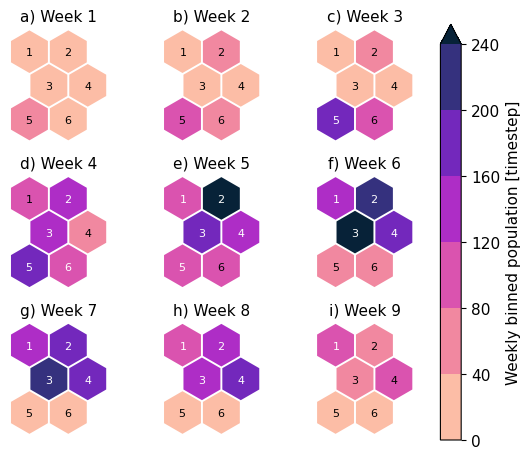

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 5.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[3]) for timestepwis in timestepwise], 0.8)
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
im = ScalarMappable(norm, cmap)
coords = net_spring.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    letter = ascii_lowercase[i]
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net_spring.n_nodes)
    to_plot[unique] = counts
    fig, ax = net_spring.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"{letter}) Week {step}", pad=2)
fig.set_tight_layout(False)

In [39]:
from scipy.stats import mode
def mode0(arr, axis):
    return mode(arr[10:], axis=axis)[0]

winners_spring = labels_spring.groupby("time.year").reduce(mode0)
all_years = np.unique(labels_spring["time"].dt.year)
year_per_winner = labels_to_mask(winners_spring)
year_per_winner = [all_years[mask] for mask in year_per_winner.T]
labels_summer_grouped = [labels_summer.sel(time=np.isin(labels_summer["time"].dt.year, year_per_winner_)) for year_per_winner_ in year_per_winner]

In [40]:
labels_summer_grouped

[<xarray.DataArray 'labels' (time: 5952)> Size: 48kB
 array([15, 15, 15, ..., 14, 14, 10])
 Coordinates:
   * time     (time) datetime64[ns] 48kB 1959-06-09T18:00:00 ... 2020-10-09T18...,
 <xarray.DataArray 'labels' (time: 5782)> Size: 46kB
 array([3, 3, 3, ..., 2, 2, 2])
 Coordinates:
   * time     (time) datetime64[ns] 46kB 1962-06-06T06:00:00 ... 2019-10-11T18...,
 <xarray.DataArray 'labels' (time: 5961)> Size: 48kB
 array([3, 3, 3, ..., 2, 2, 2])
 Coordinates:
   * time     (time) datetime64[ns] 48kB 1960-06-15T12:00:00 ... 2022-10-04T18...,
 <xarray.DataArray 'labels' (time: 6205)> Size: 50kB
 array([13, 13, 13, ..., 12, 12, 12])
 Coordinates:
   * time     (time) datetime64[ns] 50kB 1968-06-14T12:00:00 ... 2017-09-28T18...,
 <xarray.DataArray 'labels' (time: 2299)> Size: 18kB
 array([ 3,  3,  3, ..., 15, 15, 15])
 Coordinates:
   * time     (time) datetime64[ns] 18kB 1987-06-01T06:00:00 ... 2011-09-23T06...,
 <xarray.DataArray 'labels' (time: 2341)> Size: 19kB
 array([13, 13, 13,